# BERT base-uncased, soma dos score do par.

- Usando 4 datasets do artigo DIVE.

- Os primeiros gráficos mostram o balanceamento de cada dataset.
  - % dos pares True para cada tamanho de subtoken

  - Quantidade total de pares para cada tamanho de subtoken

- O último gŕafico compara o BERT com os dados do artigo. Ainda forcei os resultados: Cada dataset tem os seus melhores padrões.



In [67]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nb_utils
sns.set(style="whitegrid")
plt.clf()
method_names = {'word2vec': 'Word2vec C', 'summation_dot_product': 'DIVE \u0394S * C ', 'dot_product': 'DIVE C',
                'rnd': 'random', 'summation': 'DIVE \u0394S', 'summation_word2vec': 'DIVE \u0394S * Word2vec C',
                'all_subword mean_positional_rank': 'BERT Mean Pos Rank', 'all_subword min_positional_rank': 'BERT Min Pos Rank',
                'all_subword max_pattern': 'BERT Max Pattern', 'all_subword mean_pattern': 'BERT Mean Pattern',
                'min score_final_log(z)': 'BERT Min Pos Rank (log(z))', 'min score_final_norm': 'BERT Min Pos Rank (/ norm)',
                'mean score_final_log(z)': 'BERT Mean Pos Rank (log(z))', 'mean score_final_norm': 'BERT Mean Pos Rank (/ norm)'}


path_json = "../../en-model/bert-base-uncased-test"
dfs = {}
for filename in os.listdir(path_json):
    if os.path.isfile(os.path.join(path_json, filename)) and filename.endswith(".json"):
        df = nb_utils.create_dataframe(json.load(open(os.path.join(path_json, filename))))
        dfs[filename] = df

tmp = dfs[filename]
pattern_unique_list = tmp['pattern'].unique().tolist()
len_total_unique = tmp['len_total'].unique().tolist()

df_ratios = []
for dataset in dfs.keys():
    df_ratio = nb_utils.balanceamento(dfs[dataset], len_size=len_total_unique, patterns=pattern_unique_list)
    df_ratio['dataset'] = dataset
    df_ratios.append(df_ratio)

df_ratios = pd.concat(df_ratios)


for dataset_name, df in dfs.items():
    dfs[dataset_name] = nb_utils.logsumexp_normalization(df, len_list=len_total_unique, pattern_list=pattern_unique_list)

Balanceamento: 8 não está no dataframe!
Balanceamento: 9 não está no dataframe!
Balanceamento: 11 não está no dataframe!
Balanceamento: 10 não está no dataframe!
Balanceamento: 14 não está no dataframe!
Balanceamento: 13 não está no dataframe!
Balanceamento: 12 não está no dataframe!
Balanceamento: 11 não está no dataframe!
Balanceamento: 10 não está no dataframe!
Balanceamento: 14 não está no dataframe!
Balanceamento: 13 não está no dataframe!
Balanceamento: 12 não está no dataframe!
Balanceamento: 8 não está no dataframe!
Balanceamento: 11 não está no dataframe!
Balanceamento: 10 não está no dataframe!
Balanceamento: 14 não está no dataframe!
Balanceamento: 13 não está no dataframe!
Balanceamento: 12 não está no dataframe!


<Figure size 432x288 with 0 Axes>

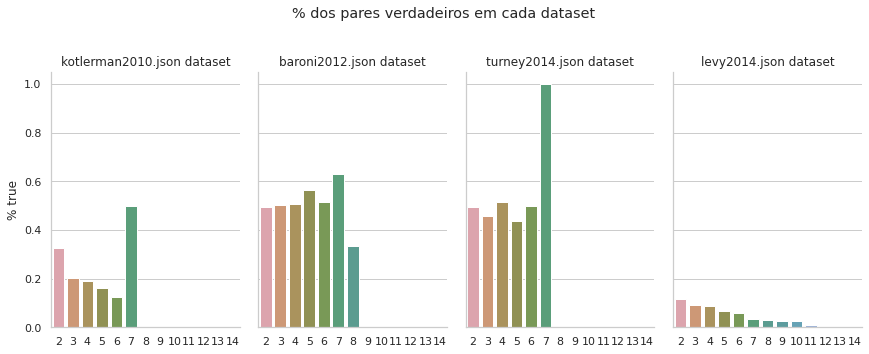

In [68]:
# % dos pares True por tamanho de subtoken
g = sns.catplot(x="len_total", y="ratio", col="dataset",
                data=df_ratios, saturation=.5,
                kind="bar", ci=None, aspect=.6)
(g.set_axis_labels("", "% true")
#   .set_xticklabels(["Men", "Women", "Children"])
  .set_titles("{col_name} {col_var}")
  # .set(ylim=(0, 1))
  .despine(left=False))
plt.subplots_adjust(top=0.8)
_ = g.fig.suptitle('% dos pares verdadeiros em cada dataset')

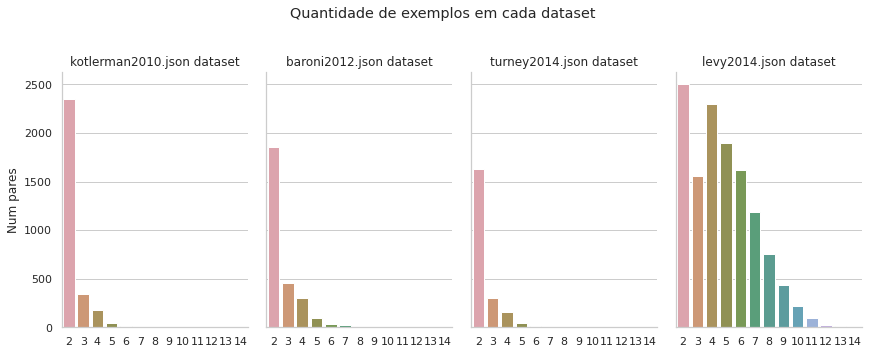

In [69]:
# Quantidade de pares por tamanho de subtoken
df_ratios['total'] = df_ratios['true'] + df_ratios['false']
g = sns.catplot(x="len_total", y="total", col="dataset",
                data=df_ratios, saturation=.5,
                kind="bar", ci=None, aspect=.6)
(g.set_axis_labels("", "Num pares")
#   .set_xticklabels(["Men", "Women", "Children"])
  .set_titles("{col_name} {col_var}")
  # .set(ylim=(0, 1))
  .despine(left=False))
plt.subplots_adjust(top=0.8)
_ = g.fig.suptitle('Quantidade de exemplos em cada dataset')


In [70]:
best_pattern_train = ['{} or some other {}', '{} or any other {}', '{} and any other {}', '{} is a type of {}', '{} and some other {}', '{} which is kind of {}', '{} a special case of {}', '{} is a {}', '{} which is a example of {}', '{} and others {}', '{} which is called {}', '{} which is a class of {}', '{} or others {}', '{} , a {}', '{} including {}']

# Melhores padrões para cada dataset
best_pattern_dataset = {}

for dataset_name, df in dfs.items():
    best_pattern_dataset[dataset_name] = nb_utils.compute_dataframe_AP_by_pattern(df, key_sort="score_final_log(z)", pattern_list=pattern_unique_list)

In [71]:
df_dive = pd.DataFrame({'dataset': ['kotlerman2010.json', 'kotlerman2010.json', 'baroni2012.json', 'baroni2012.json', 'turney2014.json','turney2014.json', 'levy2014.json', 'levy2014.json'],
                        'method': ['word2vec', 'summation_dot_product'] * 4,
                        'AP': [0.395, 0.366, 0.718, 0.835, 0.521, 0.572, 0.112, 0.192]
                        })
df_en = []
method_score = ["score_final_log(z)", "score_final_norm"]
for best_pattern_num in range(1, len(best_pattern_train)+1):
    for dataset_name, df in dfs.items():
        # best_pattern = best_pattern_dataset[dataset_name]['padrao'].iloc[:best_pattern_num].tolist()
        best_pattern = best_pattern_train[:best_pattern_num]
        for score_name in method_score[:1]:
            n_pair = df.groupby('pattern').count().iloc[0]['hiponimo']
            hyper_num = df[df['pattern'] == pattern_unique_list[0]]['fonte'].value_counts()
            hyper_num = hyper_num['hyper']
            if score_name == "score_final_log(z)":
                min_ap, mean_ap = nb_utils.compute_AP_by_rank(df, key_sort=score_name, best_patterns=best_pattern)
            elif score_name == "score_final_norm":
                min_ap, mean_ap = nb_utils.compute_AP_by_rank(df_240, key_sort=score_name, best_patterns=best_pattern)

            df = pd.DataFrame({'n_best': [best_pattern_num],'dataset': [dataset_name], 'N': [n_pair], 'hyper_num': [hyper_num], 'method': f"min {score_name}", 'AP': [min_ap]})
            df_en.append(df)
            df = pd.DataFrame({'n_best': [best_pattern_num],'dataset': [dataset_name], 'N': [n_pair], 'hyper_num': [hyper_num], 'method': f"mean {score_name}", 'AP': [mean_ap]})
            df_en.append(df)

best_pattern_num = 4
df = pd.concat(df_en)
df = df[df['n_best'] == best_pattern_num]

df = pd.concat([df, df_dive])
df['method_format'] = df['method'].map(method_names)

print(f"Usando {best_pattern_num} melhores padrões")

Usando 4 melhores padrões


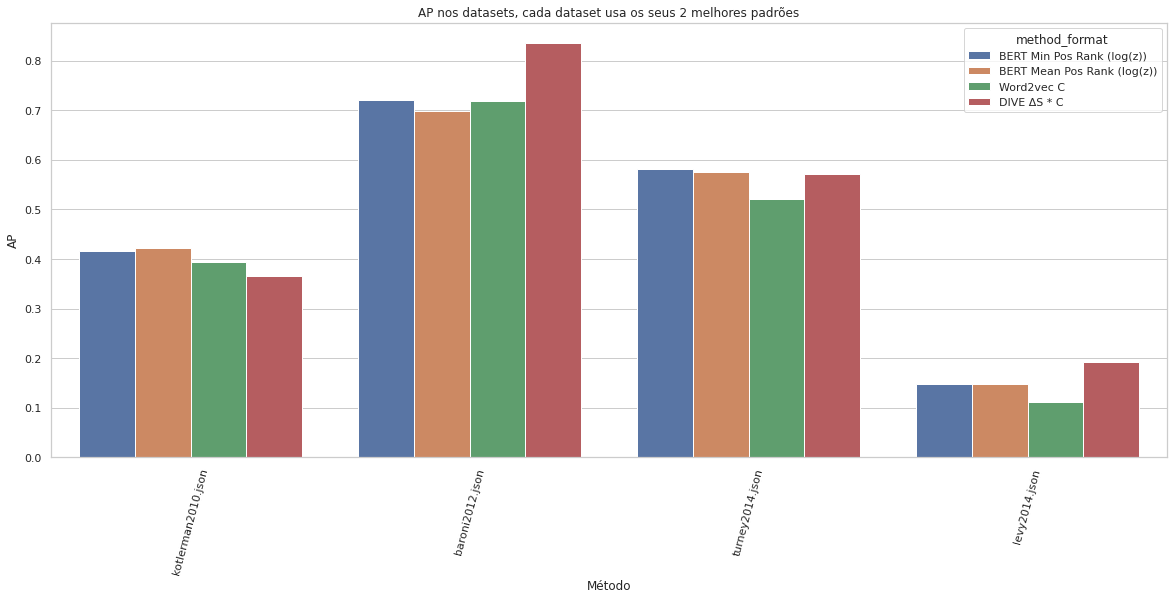

In [72]:
# AP por método
plt.figure(figsize=(20,8))
ax = sns.barplot(x='dataset' ,hue="method_format", y="AP", ci="sd",data=df)
ax.set(xlabel="Método")
ax.set_title(f"AP nos datasets, cada dataset usa os seus 2 melhores padrões")
_ = plt.xticks(rotation=75)
